# Praktikum 1

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Setup input pipeline

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Sometimes they get lucky and have a hit on their hands (Wayne's World, the first one, not the second). But most often they have duds (It's Pat comes to mind rather quickly). This time out it's Tim Meadows as The Ladies Man. This movie falls somewhere in between a hit and a dud. It was very funny for the first 20 minutes, but then, as usually happens with SNL skits, it starts to slow down, before finally ending, long after it should have.<br /><br />Tim Meadows is Leon Phelps, a radio DJ with a nightly show called The Ladies Man. He answers any and all questions dealing with sex and relationships, usually in the crudest way possible. Everything seems to ultimately come down to the butt. After pushing the buttons of the station manager, Leon, along with his producer Julie (Karyn Parsons) gets fired, and needs to find another job. Out of the random blue, comes a letter from one of his ex-ladies. The letter offers him wealth and luxury for the rest of his life, the only problem 

Buat Teks Encoder

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[505,  35,  76, ...,   1,  13,  13],
       [ 56, 472,  41, ...,   0,   0,   0],
       [ 10,   1, 492, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:
-Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
-Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Sometimes they get lucky and have a hit on their hands (Wayne's World, the first one, not the second). But most often they have duds (It's Pat comes to mind rather quickly). This time out it's Tim Meadows as The Ladies Man. This movie falls somewhere in between a hit and a dud. It was very funny for the first 20 minutes, but then, as usually happens with SNL skits, it starts to slow down, before finally ending, long after it should have.<br /><br />Tim Meadows is Leon Phelps, a radio DJ with a nightly show called The Ladies Man. He answers any and all questions dealing with sex and relationships, usually in the crudest way possible. Everything seems to ultimately come down to the butt. After pushing the buttons of the station manager, Leon, along with his producer Julie (Karyn Parsons) gets fired, and needs to find another job. Out of the random blue, comes a letter from one of his ex-ladies. The letter offers him wealth and luxury for the rest of his life, the only proble

Buat Model

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [15]:

# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 5s 5s/step
[-0.01095788]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 1s 529ms/step
[-0.01095788]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Train Model

In [36]:
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
    validation_steps=30,
    steps_per_epoch=10
)

Epoch 1/5
10/10 [==============================] - 81s 8s/step - loss: 0.3018 - accuracy: 0.8750 - val_loss: 0.3183 - val_accuracy: 0.8526
Epoch 2/5
10/10 [==============================] - 78s 8s/step - loss: 0.2679 - accuracy: 0.8797 - val_loss: 0.3248 - val_accuracy: 0.8625
Epoch 3/5
10/10 [==============================] - 78s 8s/step - loss: 0.3191 - accuracy: 0.8672 - val_loss: 0.3216 - val_accuracy: 0.8531
Epoch 4/5
10/10 [==============================] - 79s 8s/step - loss: 0.2837 - accuracy: 0.8891 - val_loss: 0.3230 - val_accuracy: 0.8562
Epoch 5/5
10/10 [==============================] - 66s 7s/step - loss: 0.3153 - accuracy: 0.8813 - val_loss: 0.3219 - val_accuracy: 0.8573


In [37]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 329s 841ms/step - loss: 0.3173 - accuracy: 0.8600
Test Loss: 0.3172752857208252
Test Accuracy: 0.8600000143051147


(0.0, 0.3276698410511017)

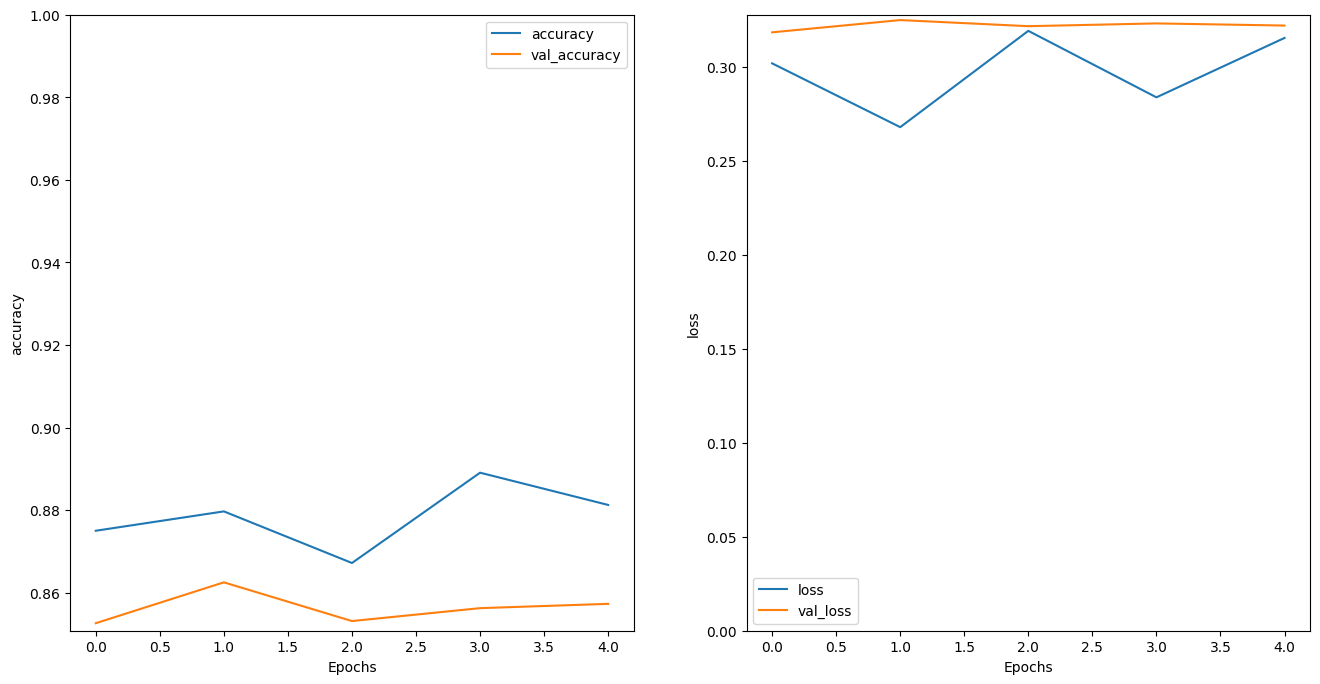

In [38]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:
Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [39]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 0s 38ms/step


Stack two or more LSTM layers
Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [40]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [41]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [42]:
# history = model.fit(train_dataset, epochs=10,
#                     validation_data=test_dataset,
#                     validation_steps=30)
history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset,
    validation_steps=30,
    steps_per_epoch=10
)

Epoch 1/3
10/10 [==============================] - 114s 9s/step - loss: 0.6935 - accuracy: 0.5203 - val_loss: 0.6934 - val_accuracy: 0.4917
Epoch 2/3
10/10 [==============================] - 76s 8s/step - loss: 0.6929 - accuracy: 0.5094 - val_loss: 0.6934 - val_accuracy: 0.4917
Epoch 3/3
10/10 [==============================] - 80s 8s/step - loss: 0.6931 - accuracy: 0.4938 - val_loss: 0.6933 - val_accuracy: 0.4917


In [43]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 326s 833ms/step - loss: 0.6932 - accuracy: 0.5000
Test Loss: 0.6931624412536621
Test Accuracy: 0.5


In [44]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-0.01597455]]


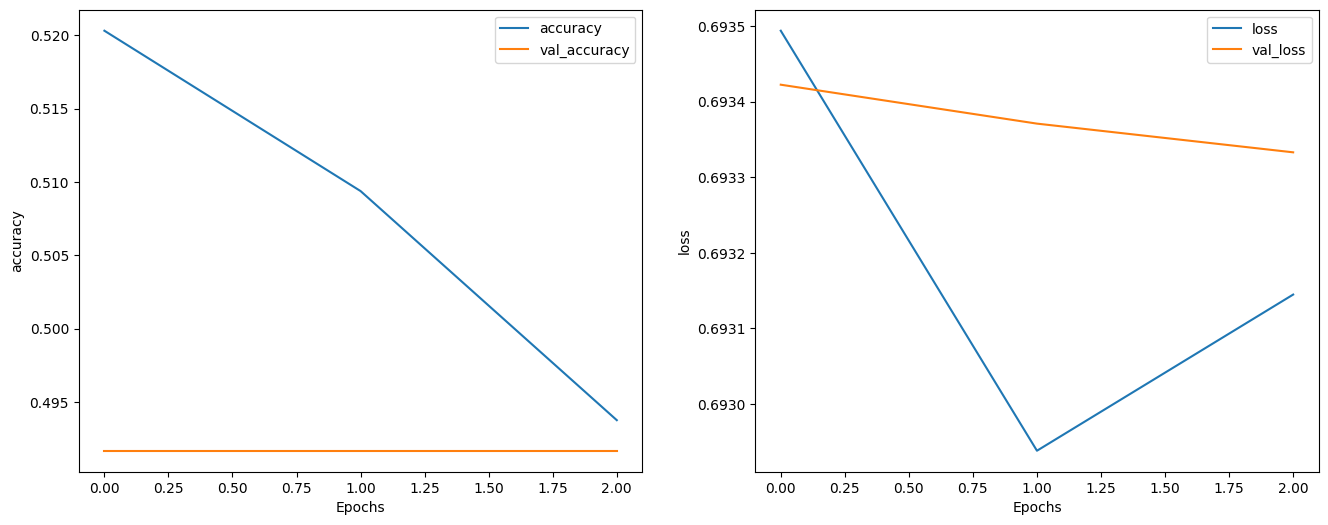

In [45]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')